In [1]:
from google.colab import files
uploaded = files.upload()


Saving BD_weather.csv to BD_weather.csv


In [8]:
# 🧩 STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [9]:
# 🧩 STEP 2: Load Dataset
df = pd.read_csv("BD_weather.csv")

# Create and clean date column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
df = df.dropna(subset=['Date'])
df = df[['Date', 'Station', 'Temperature', 'Humidity', 'Rainfall']].dropna()



In [10]:
# 🧩 STEP 3: Define Analysis Function
def analyze_city_extremes(df, station_name):
    city_df = df[df['Station'].str.lower() == station_name.lower()].copy()
    city_df = city_df.set_index('Date').sort_index()

    # Simulate synthetic load
    np.random.seed(42)
    days = len(city_df)
    base = 220
    seasonal = 30 * np.sin(2 * np.pi * city_df.index.dayofyear / 365.25)
    noise = np.random.normal(0, 10, days)
    city_df['Load (MW)'] = base + seasonal + noise

    # Calculate thresholds
    temp_thresh = city_df['Temperature'].quantile(0.85)
    load_thresh = city_df['Load (MW)'].quantile(0.90)

    # Flag extreme events
    city_df['High Temp'] = city_df['Temperature'] > temp_thresh
    city_df['High Load'] = city_df['Load (MW)'] > load_thresh
    city_df['Extreme Event'] = city_df['High Temp'] & city_df['High Load']

    # Monthly resample
    monthly_extremes = city_df['Extreme Event'].resample('M').sum()

    return city_df, monthly_extremes



In [11]:
# 🧩 STEP 4: Run for Multiple Cities
dhaka_df, dhaka_events = analyze_city_extremes(df, 'Dhaka')
ctg_df, ctg_events = analyze_city_extremes(df, 'Chittagong')
raj_df, raj_events = analyze_city_extremes(df, 'Rajshahi')

# Combine into a DataFrame
multi_region_df = pd.DataFrame({
    'Dhaka': dhaka_events,
    'Chittagong': ctg_events,
    'Rajshahi': raj_events
})





<ipython-input-10-32c37aa8892d>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_extremes = city_df['Extreme Event'].resample('M').sum()
<ipython-input-10-32c37aa8892d>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_extremes = city_df['Extreme Event'].resample('M').sum()
<ipython-input-10-32c37aa8892d>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_extremes = city_df['Extreme Event'].resample('M').sum()


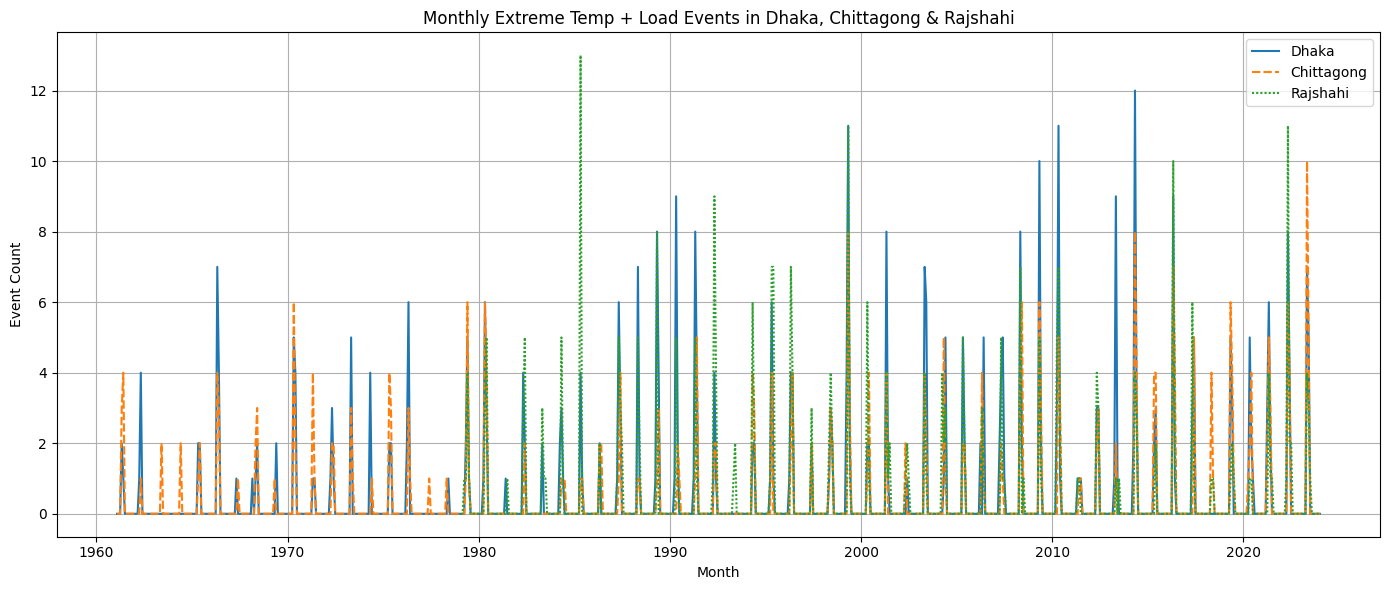

In [12]:
# 🧩 STEP 5: Plot Result
plt.figure(figsize=(14, 6))
sns.lineplot(data=multi_region_df)
plt.title("Monthly Extreme Temp + Load Events in Dhaka, Chittagong & Rajshahi")
plt.xlabel("Month")
plt.ylabel("Event Count")
plt.grid(True)
plt.tight_layout()
plt.show()


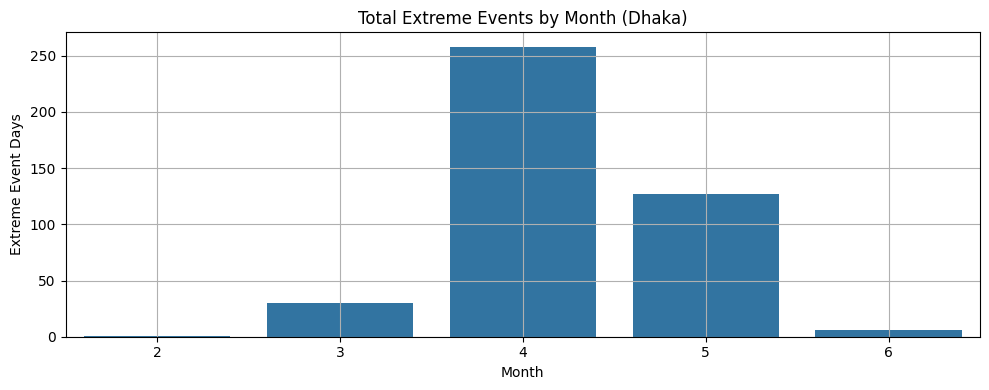

In [13]:
# Count of extreme events per month (across years)
monthly_trend = dhaka_df[dhaka_df['Extreme Event']].index.month.value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_trend.index, y=monthly_trend.values)
plt.title("Total Extreme Events by Month (Dhaka)")
plt.xlabel("Month")
plt.ylabel("Extreme Event Days")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-16-ae663a8a6d4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['Year'] = heatmap_df.index.year
<ipython-input-16-ae663a8a6d4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['Month'] = heatmap_df.index.month


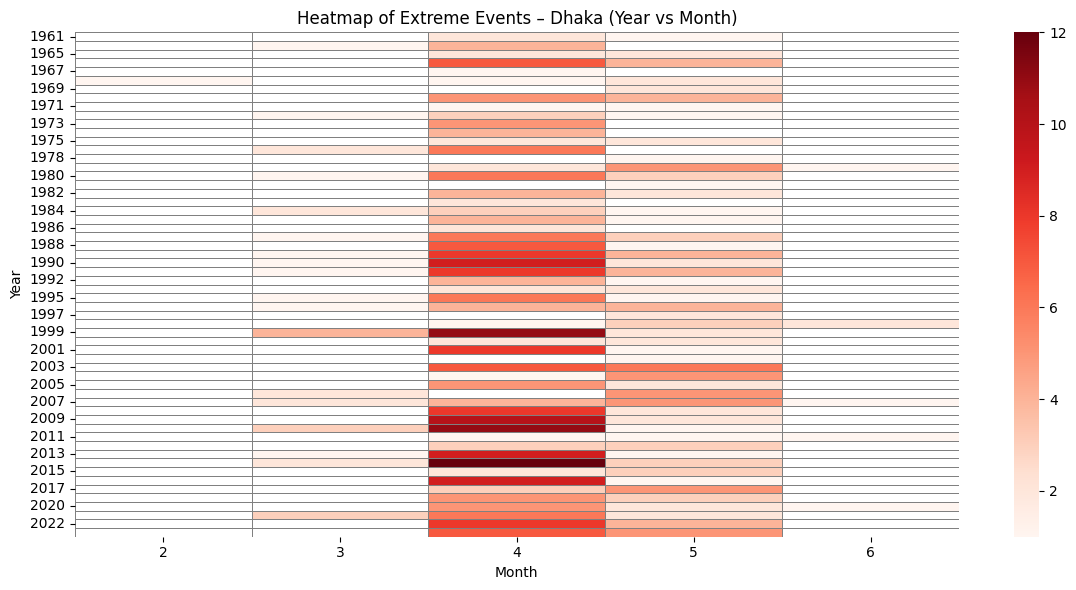

In [16]:
heatmap_df = dhaka_df[dhaka_df['Extreme Event']]
heatmap_df['Year'] = heatmap_df.index.year
heatmap_df['Month'] = heatmap_df.index.month

pivot = heatmap_df.pivot_table(index='Year', columns='Month', values='Extreme Event', aggfunc='sum')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="Reds", linewidths=0.5, linecolor='gray', annot=False)
plt.title("Heatmap of Extreme Events – Dhaka (Year vs Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


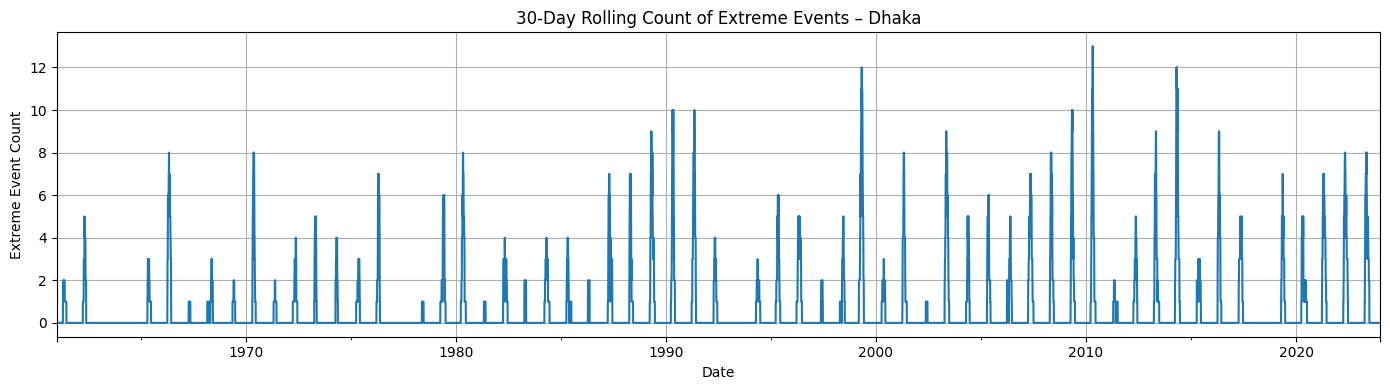

In [17]:
rolling = dhaka_df['Extreme Event'].rolling(window=30).sum()

plt.figure(figsize=(14, 4))
rolling.plot()
plt.title("30-Day Rolling Count of Extreme Events – Dhaka")
plt.xlabel("Date")
plt.ylabel("Extreme Event Count")
plt.grid(True)
plt.tight_layout()
plt.show()


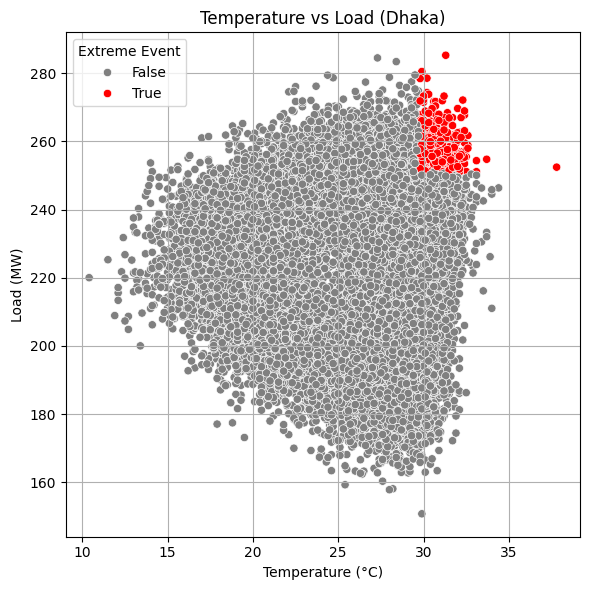

In [18]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=dhaka_df['Temperature'], y=dhaka_df['Load (MW)'],
                hue=dhaka_df['Extreme Event'], palette={True: 'red', False: 'gray'})
plt.title("Temperature vs Load (Dhaka)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()
